# GBRDC example workflow - python code

### Ariella Arzey and Hugo Fahey

*Environmental Futures, School of Earth, Atmospheric and Life Sciences, University of Wollongong, Wollongong, New South Wales, Australia\
Securing Antarctica’s Environmental Future, University of Wollongong, Wollongong, New South Wales, Australia*



This notebook documents an example of how a user can process, subset, and visualise the database data. This workflow produces two types of figures, filtering a subset from the database; line plots for visualising the record data and maps for visualising locations. Data is filtered by sampling resolution, geochemical proxy, age, and region on the Great Barrier Reef.

### Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
import numpy as np
import warnings
from astropy.time import Time
import calendar
import itertools
import math
import requests
import zipfile

### Load and format the data
Load in the metadata and database files\
v1.0 is the current version as of Feb. 2024. Later it may be necessary to update the number to match the most recent file version.

In [2]:
#read meta data from csv into a dataframe
metaD = pd.read_csv("../GBRCD CSV version/GBRCD_metadata_v1.0.csv") 

# directory of all data files as a list
data_files_dec = [file for file in os.listdir("../GBRCD CSV version/GBRCD_files_v1.0/") if file.endswith(".csv")]

# Read each CSV file and store it in a dictionary of dataframes with names for each file
data_dec1 = {} # dictionary to store DataFrames
for file in data_files_dec:
    df = pd.read_csv(os.path.join("../GBRCD CSV version/GBRCD_files_v1.0/", file))
    dataset_name = os.path.splitext(file)[0]  # Remove the ".csv" extension text
    data_dec1[dataset_name] = df

##### Check top and bottom 5 rows of the GBRCD_metadata. For better visualisation, only the first 4 columns are viewed here.

In [3]:
# Metadata overview
# Display the first and last five rows, (with only the first seven columns)
metaD.iloc[:, :7]

,cdata_datasetID,cdata_coreName,cdata_altCoreName,cdata_collectTime,cdata_minYear,cdata_maxYear,cdata_archiveSpecies
0,AL03DAV01_1,Davies 2,Davies 2 side,1993-10,1989,1993,Porites mayeri
1,AL03DAV01_2,Davies 2,Davies 2 side,1993-10,1989,1993,Porites mayeri
2,AL03PAN01_1,PAN 98-2,PAN 98-2 B3,1998-10,1993,1998,Porites sp.
3,AL03PAN01_2,PAN 98-2,PAN 98-2 B3,1998-10,1993,1998,Porites sp.
4,AL03PAN01_3,PAN 98-2,PAN 98-2 B1,1998-10,1988,1994,Porites sp.
...,...,...,...,...,...,...,...
203,WU21MAS01a,MAS02A,NaN,2017-08,1907,2017,Porites sp.
204,WU21MAS01b,MAS01E,NaN,2017-08,1946,2017,Porites sp.
205,WU21SHW01,SHW82C,NaN,NaN,1949,2017,Porites sp.
206,WU21SMI01,SMI81A,NaN,2018-02,1975,2017,Porites sp.


##### Join the datafiles with the metadata

In [4]:
# directory of all data files as a list
data_files_dec = [file for file in os.listdir("../GBRCD CSV version/GBRCD_files_v1.0/") if file.endswith(".csv")]

# Read each CSV file and store it in a dictionary of dataframes with names for each file
data_dec1 = {} # dictionary to store DataFrames
for file in data_files_dec:
    df = pd.read_csv(os.path.join("../GBRCD CSV version/GBRCD_files_v1.0/", file))
    dataset_name = os.path.splitext(file)[0]  # Remove the ".csv" extension
    data_dec1[dataset_name] = df

In [5]:
# Loop through the data_dec1 dictionary and add a new column to each dataframe for the site ID
data_dec_ID = [] #new empty list to store dataframes with added ID column
for dataset_name, df in data_dec1.items():
    df['cdata_datasetID'] = dataset_name
    data_dec_ID.append(df)

In [6]:
# Define a function to apply the data joining using the added data ID column
def join_dataframe(df):
    # Left join with metaD DataFrame
    merged_df = df.merge(metaD[['cdata_datasetID', 
                                'geo_latitude', 
                                'geo_longitude', 
                                'geo_siteName', 
                                'meths_isAnomaly', 
                                'meths_primaryVariablesList', 
                                'meths_hasResolutionNominal',
                                'meths_resolutionMedian']],
                on='cdata_datasetID', how='left')
    
    # Define a function within this function for defining GBR region based on latitude value
    def get_region(latitude):
        if latitude > -17:
            return "North"
        elif latitude < -20:
            return "South"
        else:
            return "Central"
    
    # Apply the region function
    merged_df['Region'] = merged_df['geo_latitude'].apply(get_region)

    # convert decimal dates to days, months, and years 
# for positive value ages 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning) #as each negative age produces an warning message
        time_objects = []
        for decimal_year in merged_df['Age']: # a work around for negative values causing issues
            try:
                time_objects.append(Time(decimal_year, format='decimalyear')) 
            except Exception:
                time_objects.append(None)
                
        # create new coloums in dataframes for formatted date, month, and year
        merged_df['dates'] = [pd.to_datetime(t.datetime64) if t is not None else pd.NaT for t in time_objects]
        merged_df['Month'] = merged_df['dates'].dt.month
        merged_df['Year']  = merged_df['dates'].dt.year
        
# for negative value ages 
        # Working with the negative age values manually and keeping a time object with astropy (instead of converting back into datetime)
        # (date and time objects do not support years before 1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        time_objects = []
        failed_sites = set() # List to store sites that failed processing
        for decimal_year, site_ID in zip(merged_df['Age'], merged_df['cdata_datasetID']):
            if decimal_year < 0: 
                try:
        # Create a Time object with BCE date from the negative decimal dates
                    # BCE_date = Time(decimal_year, format='decimalyear')
                    if decimal_year > -4800:
                        BCE_date = Time(decimal_year, format='decimalyear')
                    else:
                        BCE_date = Time(decimal_year, format='jyear') # astropy only defines calander dates back to 4799 BCE
                    
        # Extract year, month, and day components
                    BCE_year = int(BCE_date.value) # the database conversion does not include 'year 0' (year 1 BCE is decimal date -1)
                    
                    # Calculate day of year
                    day_of_year = abs(decimal_year - int(BCE_year)) * (366 if calendar.isleap(BCE_year) else 365)
                    day_of_year = (366 if calendar.isleap(BCE_year) else 365) - day_of_year
                    
                    # Determine month based on day_of_year
                    month_lengths = [31, (29 if calendar.isleap(BCE_year) else 28), 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # month bins
                    BCE_month = next((i for i, accum_days in enumerate(itertools.accumulate(month_lengths)) if accum_days>=day_of_year),
                                      len(month_lengths)) + 1 #counting through the month bins
    
                    # Calculate day of month - subtract total of month lengths upto the current month and take the positive value
                    day_of_month = abs(int(day_of_year - sum(month_lengths[:BCE_month])))+1 #add 1 so that we start from 1st (no day 0)
                    
        # Assign components to each DataFrame - in line with where the 'Age' coloum equals the decimal_year variable
                    merged_df.loc[merged_df['Age'] == decimal_year, 'Year'] = BCE_year
                    merged_df.loc[merged_df['Age'] == decimal_year, 'Month'] = abs(int(BCE_month))
                    # repoulate the 'dates' column with a string of the format year-month-day (a datetime object cannot be negative)
                    merged_df.loc[merged_df['Age'] == decimal_year, 'dates'] = f"{BCE_year:04d}-{BCE_month:02d}-{day_of_month:02d}"
                except Exception:
                    failed_sites.add(site_ID)
                    
    if failed_sites: # to keep track in case of any negative age values that were not able to be converted
        print(', '.join(list(failed_sites)), "was not able to be converted to a valid date")
    return merged_df

## NOTE: be aware that the datetime module only supports CE dates so the dates fields for all BCE entries will be a string

In [7]:
# Apply the joining function to each DataFrame (in data_dec_ID)
## NOTE: this cell takes a bit of time to run
new_df = [join_dataframe(df) for df in data_dec_ID]

# NOTE: Giving all the new dataframes the name key of each equivelent input data file for ease of reference
# NOTE: e.g. to call the information for a given site (e.g. AL03DAV01_1): new_df_named['AL03DAV01_1']
new_df_named = {}
for dataset_name, df in zip(data_dec1.keys(), new_df):
    new_df_named[dataset_name] = df

##### Check an example of the joined data for a given site - AL03DAV01_1 (visualise the top, bottom 5 rows, and the first 4 columns)

In [8]:
# Display the first and last five rows, (with only the first seven columns) of a single dataframe in "new_df"
new_df_named['AL03DAV01_1'].iloc[:, :7]

,Age,SrCa,Distance,cdata_datasetID,geo_latitude,geo_longitude,geo_siteName
0,1989.497260,9.09220,53.75,AL03DAV01_1,-18.8,147.7,Davies Reef
1,1989.524658,9.10272,53.50,AL03DAV01_1,-18.8,147.7,Davies Reef
2,1989.549315,9.12891,53.25,AL03DAV01_1,-18.8,147.7,Davies Reef
3,1989.576712,9.11528,53.00,AL03DAV01_1,-18.8,147.7,Davies Reef
4,1989.604110,9.11299,52.75,AL03DAV01_1,-18.8,147.7,Davies Reef
...,...,...,...,...,...,...,...
210,1993.700000,9.00660,1.25,AL03DAV01_1,-18.8,147.7,Davies Reef
211,1993.721918,9.00262,1.00,AL03DAV01_1,-18.8,147.7,Davies Reef
212,1993.746575,8.97722,0.75,AL03DAV01_1,-18.8,147.7,Davies Reef
213,1993.768493,8.99205,0.50,AL03DAV01_1,-18.8,147.7,Davies Reef


### Filter datasets by proxies, resolution, etc.
Attach relevant metadata fields to datasets and filter by properties e.g. Proxy - meths_primaryVariablesList, Resolution - meths_resolutionMedian
Ba/Ca is used as an example variable to filter the GBRCD
<br/><br/>

#### Suggested fields for filtering:

Record coverage (this is  number of years of data - it accounts for temporal gaps):
   - cdata_dataCoverageGroup

Proxy Type: 
   - meths_primaryVariablesList (e.g. BaCa, d11B, d18O, SrCa)
   - meths_additionalVariablesList (e.g. d18Osw, d11B_ph)

Temporal Coverage (this is total temporal span of records):
   - cdata_minYear (record start year)
   - cdata_maxYear (record end year)

Record Resolution:
   - meths_hasResolutionNominal (nominal resolution)
   - meths_resolutionMax (maximum resolution; data points per year)
   - meths_resolutionMin (minimum resolution; data points per year)
   - meths_resolutionMean    (mean resolution; data points per year)
   - meths_ResolutionMedian  (median resolution; data points per year)

Location:
   - geo_latitude  (record latitude; degrees N (all GBR latitudes are negative))
   - geo_longitude (record longitude; degrees E (all GBR longitudes are positive))
   - geo_siteName  (name of the site/reef)

Species: cdata_archiveSpecies
Record Method:
   - meths_[x]Method (method used for trace element measurement; [x] should be replaced by choice of data i.e TE = trace element, isotope, lumin = luminescence)

SST Calibration:
   - calib_isSSTCalibration (record is SST calibration dataset (SrCa, UCa, d18O); T/F)
   - calib_useSSTCalibration (record uses SST calibration (SrCa, UCa, d18O); T/F)

(All metadata fields may be be used for filtering, but the above list above includes the suggested starting point for investigating the data)

In [9]:
# Define a function to filter out only files that include;
# at least bimonthly temporal resolution, Ba/Ca data, since the year 1500
def BaCa_filter(df):
    # Filter rows based on meths_resolutionMedian equal or greater than 6
    df = df[df['meths_resolutionMedian'] >= 6]
    
    # Check if 'BaCa' is in column names and create 'BACA_yes'
    if 'BaCa' in df.columns:
        df['BACA_yes'] = 'Yes'
    else:
        df['BACA_yes'] = None

    # Set 'BACA_yes' to NA where 'meths_isAnomaly' is TRUE
    df.loc[df['meths_isAnomaly'] == True, 'BACA_yes'] = None
    
    # Filter rows based on 'Age' greater than 1500
    df = df[df['Age'] > 1500]

    # drop rows with no Ba/Ca data (NA in 'BACA_yes')
    df = df.dropna(subset=['BACA_yes'])
    
    # Remove the working 'BACA_yes' column
    df = df.drop(columns=['BACA_yes'])
    
    return df

In [10]:
# Apply the filtering function to each DataFrame in new_df
baca_IDRegion = [BaCa_filter(df) for df in new_df] 

# remove the dataframes with no rows (as they were removed by the filter function)
baca_IDRegion = list(filter(lambda x: len(x) > 0, baca_IDRegion))

#filter duplicates (lowest sst correlation records removed)
# Define a list of dataset IDs to exclude (if necessary)
exclude_ids = [] # e.g. ['site_ID_1', 'site_ID_2']
# Filter out rows with the specified dataset IDs (given in exclude_ids)
baca_IDRegion = [df[~df['cdata_datasetID'].isin(exclude_ids)] for df in baca_IDRegion]

# again a named dictionary of Ba/Ca containing dataframes for ease of referencing
baca_IDRegion_named = {}
for dataset_name, df in zip(data_dec1.keys(), baca_IDRegion):
    baca_IDRegion_named[dataset_name] = df

# combine the filtered DataFrames into a single DataFrame
baca_IDRegion_DF = pd.concat(baca_IDRegion, ignore_index=True)

##### Check how many sites meet the filters

In [11]:
# Number of sites that have Ba/Ca post year 1500
print('Number of sites that have Ba/Ca record post 1500:', len(baca_IDRegion_named))

Number of sites that have Ba/Ca record post 1500: 68


##### List all of those site IDs

In [12]:
# List of all sites that have a bimonthly Ba/Ca record post year 1500
BaCa_list = list(baca_IDRegion_named.keys())
# to create a neat string from the list object
BaCa_list = ', '.join(BaCa_list)

print(BaCa_list)

DO18LIZ01, LE12CID01, RE19GBR01, WA19ARL01, DO22PAN02, DO15GBR01, LE12WHI01, LO14NEL02, AR24OTI01, LO14NEL03, LE18NEL01, DO22ARL01, LO11COO01, LE18PAN01, LE12CID02, XI20ARL01, FA00PAN01, DO22BRT01, DO22PAN01, LO14NEL01, AR24OTI02, AR24OTI03, LE12NMI01, LE18NEL02, DR99HER01, LE18PAN02, LO11ACH01, LE12CID03, JU08KES02, JU08SCA01, LE16GPI01, SA16HER06b, LO11HKI02, LO14NEL04, LO14NEL05, LE05NEL02, DO15HAV01, LO11GPI01, LE19HIG01, JU08KES03, FA03HAV01, JU08SCA02, DO22HIG01, LE16GPI02, WU21SMI01, SA16HER06a, DO15HAV03, AR24OTI04, LO11HKI01, LO14NEL07, LO14NEL06, LE05NEL01, AR24OTI05, DO15HAV02, LE16GPI03, JU08SCA03, DO18RIB01, MC03PAN01, HE03GPI01, LE07MAG01, EL19OTI01, LE18GFB02, FA03WHE01, FA03ORP01, JU08RTI01a, LE19RUS01, RO14KIN01, WU21MAS01a


### Plot GBRCD Ba/Ca

#### Plotting all ‘modern’ bimonthly or higher resolution Ba/Ca data (entire GBR & southern GBR)
For ease of viewing, the y-axis, Ba/Ca values have been filtered to all values <0.1\
The Legend is omitted due to large number of records reducing legibility

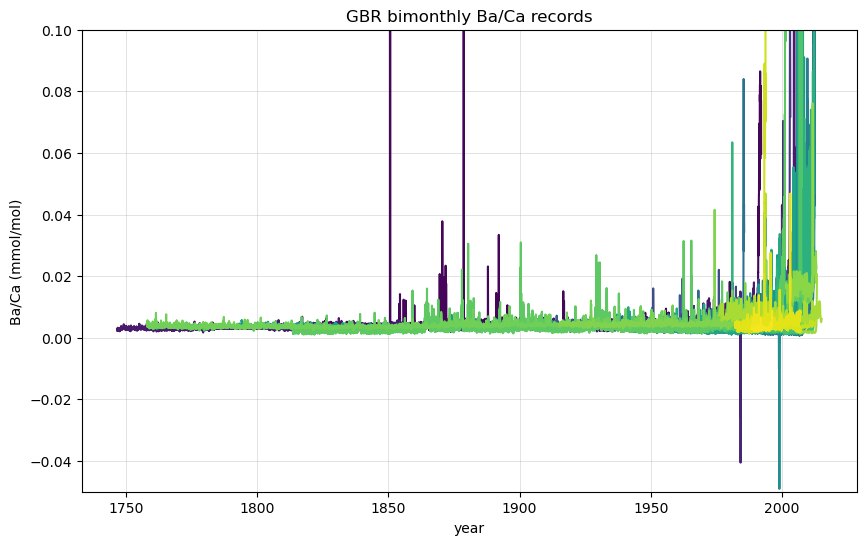

In [13]:
# all ‘modern’ bimonthly or higher resolution BaCa data (as filtered in BaCa_filter above)
plt.figure(figsize=(10, 6))
sns.lineplot(data=baca_IDRegion_DF, x='Age', y='BaCa', hue='cdata_datasetID', palette='viridis')

# set a limit of 0.1 for the y-axis data
# min at nearest hundredth to the minimun of the data to max at 0.1
plt.ylim(math.floor(min(baca_IDRegion_DF['BaCa'])*100)/100, 0.1)

# Labels and legend
plt.xlabel('year')
plt.ylabel('Ba/Ca (mmol/mol)')
plt.title('GBR bimonthly Ba/Ca records')
plt.grid(True, linewidth=0.5, alpha=0.5) # plot grid lines
# Hide the legend
plt.legend().set_visible(False) # to plot the legend of sites, comment this line and uncomment the line below
# plt.legend(title='Site', bbox_to_anchor=(1.05, 1), loc='upper left') # legend outside main plot

plt.show()

#### Plotting just the sites from the southern Great Barrier Reef

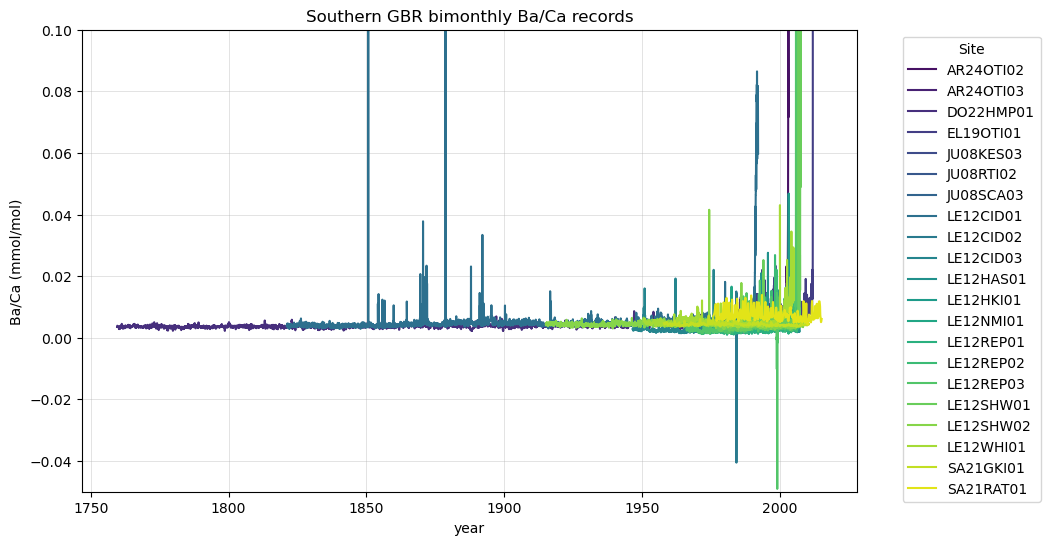

In [14]:
# Plot only the southern classified sites
# Filter rows for the Northern GBR 
baca_IDRegion_South = baca_IDRegion_DF[baca_IDRegion_DF['Region'] == "South"]

#plot southern GBR 
plt.figure(figsize=(10, 6))
sns.lineplot(data=baca_IDRegion_South, x='Age', y='BaCa', hue='cdata_datasetID', palette='viridis',
             hue_order=sorted(baca_IDRegion_South['cdata_datasetID'].unique())) # legend in alphabetical order

# set a limit of 0.1 for the y-axis data (buffer of 0.02 for plot aesthetics)
plt.ylim(math.floor(min(baca_IDRegion_DF['BaCa'])*100)/100, 0.1) 

# Labels and legend
plt.xlabel('year')
plt.ylabel('Ba/Ca (mmol/mol)')
plt.title('Southern GBR bimonthly Ba/Ca records')
plt.grid(True, linewidth=0.5, alpha=0.5) # plot grid lines
plt.legend(title='Site', bbox_to_anchor=(1.05, 1), loc='upper left') # legend outside main plot

plt.show()

#### Individually display Ba/Ca records located south of latitude -22.5° on separate vertically stacked subplots sharing the x axis

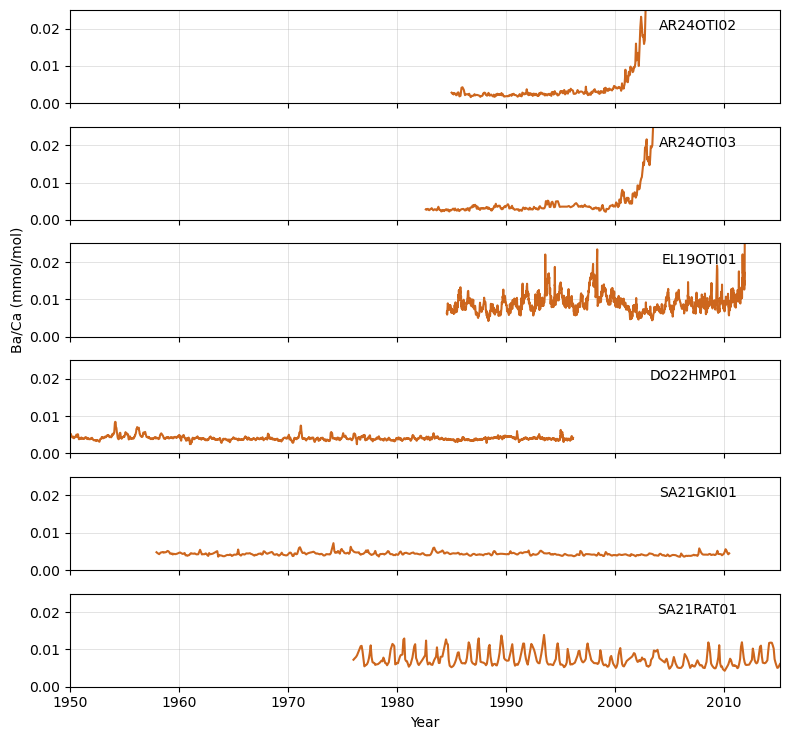

In [15]:
# Get cdata_datasetIDs for sites south of latitude -22.5
selected_sites = baca_IDRegion_South[baca_IDRegion_South['geo_latitude'] < -22.5]['cdata_datasetID'].unique()

# Create subplots, stacked in one coloum
fig, axes = plt.subplots(len(selected_sites), 1, figsize=(8, 1.25 * len(selected_sites)), sharex=True)

# Iterate through selected sites and plot each record on a separate axis
for i, cdata_datasetID in enumerate(selected_sites):
    # Filter data for the current site in the loop and plot on the corresponding axis
    site_data = baca_IDRegion_South[baca_IDRegion_South['cdata_datasetID'] == cdata_datasetID]
    sns.lineplot(data=site_data, x='Age', y='BaCa', ax=axes[i], color='#CD661D')
    
    # Set axis limits - yaxis top at 0.025, and xaxis starts at 1950
    axes[i].set_ylim(0, 0.025)
    axes[i].set_xlim(1950, max(baca_IDRegion_DF['Age']))

    # Labels
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('')#no labels on each individual yaxis
    axes[i].grid(True, linewidth=0.5, alpha=0.5) # gridlines
    axes[i].set_title('')#no titles above each plot, instead in the following line add the text within the plot
    axes[i].text(0.94, 0.9, cdata_datasetID, transform=axes[i].transAxes, horizontalalignment='right', verticalalignment='top')
# add a single yaxis title on the third plot from the top    
middle_ax = axes[len(selected_sites) // 3]
middle_ax.set_ylabel('Ba/Ca (mmol/mol)')

plt.tight_layout() #avoid overlapping of multiple plot elements
plt.show()

### Mapping - Ba/Ca records

##### Create and acquire the variables required for mapping;
Queensland coastline shapefile, filter Ba/Ca metadata, make sure all the spatial data in in the same coordinate reference system

In [16]:
# functions for downloading and unzipping a file from a url

# Get a filename from content-disposition url
def get_filename_from_cd(cd):
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0]

# Download a file from a url to a given file path
def download_file(url, destination_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destination_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"File downloaded successfully to {destination_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
        
# unzip a .zip file in a given file path to a given file path
def unzip_file(zip_file_path, extraction_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"File successfully extracted to {extraction_path}")

In [17]:
# Obataining the shapefile for the Queensland coastline to use in mapping (from Australian government)

download_url = "https://data.gov.au/data/dataset/2dbbec1a-99a2-4ee5-8806-53bc41d038a7/resource/"\
               "a2440bb6-2ad2-4c20-aaab-c0ceb013033e/download/qld_state_polygon_shp_gda2020.zip"
download_destination = "./additional/shapefiles/"
req = requests.get(download_url, allow_redirects=True)
download_filename = get_filename_from_cd(req.headers.get('content-disposition'))


# create the destination directory if it doesn't already exist
if not os.path.exists(download_destination):
    # If not, create it
    os.makedirs(download_destination)
    print(f"Directory '{download_destination}' created.")
else:
    print(f"Directory '{download_destination}' already exists.")
    
    
# download the file if if it doesn't already exist in the designated download directory
# (to avoid unintentionally overwriting files)
if not os.path.exists(os.path.join(download_destination, download_filename)):
    # If not, create it
    download_file(download_url, os.path.join(download_destination, download_filename))
else:
    print(f"Directory '{os.path.join(download_destination, download_filename)}' already exists.")

    
# unzip the file if it hasn't already been unzipped in the given directory
# Check if the given directory contains any files with the same name string as the .zip file
existing_files = [file for file in os.listdir(download_destination) 
                  if file.lower().startswith(os.path.splitext(download_filename)[0])]
if len(existing_files) <= 1:
    # If there is one or no such file, the zip file hasn't been unzipped yet
    # Ensure the extraction path exists
    os.makedirs(download_destination, exist_ok=True)
    # Proceed with unzipping the file
    unzip_file(os.path.join(download_destination, download_filename), download_destination)
else:
    print(f"File '{download_filename}' has already been unzipped in '{download_destination}'.")

Directory './additional/shapefiles/' already exists.
Directory './additional/shapefiles/qld_state_polygon_shp_gda2020.zip' already exists.
File 'qld_state_polygon_shp_gda2020.zip' has already been unzipped in './additional/shapefiles/'.


In [18]:
# create the variables to be used for maps from the database

# Study area dataframe
qldmap = gpd.read_file('./additional/shapefiles/qld_state_polygon_shp_gda2020.shp')
qldmap = qldmap.to_crs(epsg=4283) # make sure the data is all in the same coordinate reference system

# Filter metadata for Ba/Ca record
metaD_baca = metaD.copy()
metaD_baca['BACA_yes'] = metaD_baca['meths_primaryVariablesList'].apply(lambda x: 
                                    'Yes' if re.search(r'BaCa', str(x)) else None)
metaD_baca = metaD_baca.dropna(subset=['BACA_yes'])

# Filter metadata for Ba/Ca record and group by site
metaD_bacaGRP = metaD_baca.groupby('geo_siteName').agg(lat=('geo_latitude', 'mean'), 
                                                       long=('geo_longitude', 'mean'), 
                                                       counts=('geo_siteName', 'size')).reset_index()

# Convert Ba/Ca metadata into a pandas GeoDataFrame
BaCa_gdf = gpd.GeoDataFrame(metaD_baca, geometry=gpd.points_from_xy(metaD_baca['geo_longitude'], 
                                                                    metaD_baca['geo_latitude']),crs="EPSG:4283")

# Convert Ba/Ca grouped metadata into a geodataframe
BaCaGRP_gdf = gpd.GeoDataFrame(metaD_bacaGRP, geometry=gpd.points_from_xy(metaD_bacaGRP['long'], 
                                                                          metaD_bacaGRP['lat']),crs="EPSG:4283")

##### Mapping all bimonthly or higher resolution Ba/Ca data

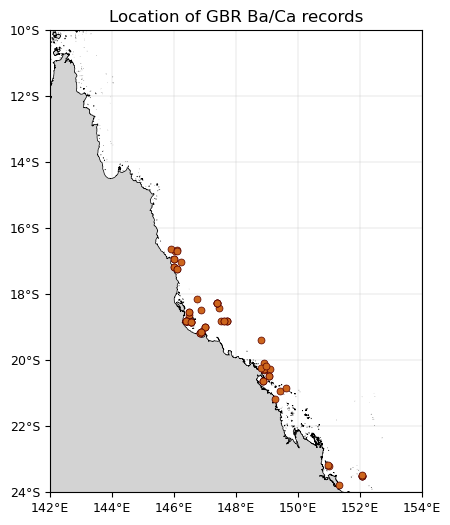

In [19]:
# Map of Ba/Ca records in the database
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Queensland's boundary
qldmap.boundary.plot(ax=ax, color='black', facecolor='lightgrey', linewidth=0.5, zorder=2)

# Plot Ba/Ca records
BaCa_gdf.plot(ax=ax, color='#CD661D', edgecolor='#570000',linewidth=0.5, markersize=25, label='Ba/Ca', zorder=3)

# Set plot limits
ax.set_xlim(142.5, 153)
ax.set_ylim(-24, -10.5)

# Set titles and labels
ax.set_title("Location of GBR Ba/Ca records")
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
#plt.yticks(rotation=90, va='centre') # if you want to rotate y-tick labels
ax.grid(zorder=1,linewidth=0.2)

# make axis labels into degrees south and east
yticks = ax.get_yticks()
yticklabels = [f"{int(abs(y))}°S" for y in yticks] #by takeing the absolute value of the interger and adding °S
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
plt.yticks(fontsize=9)

xticks = ax.get_xticks()
xticklabels = [f"{int(abs(x))}°E" for x in xticks] #by takeing the absolute value of the interger and adding °E
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
plt.xticks(fontsize=9)
# legend: uncomment the below line if a legend of the proxy marker is desired 
#ax.legend(loc='upper right')#, title='Legend')

plt.show()

##### Mapping point sizes relative to number of records per site

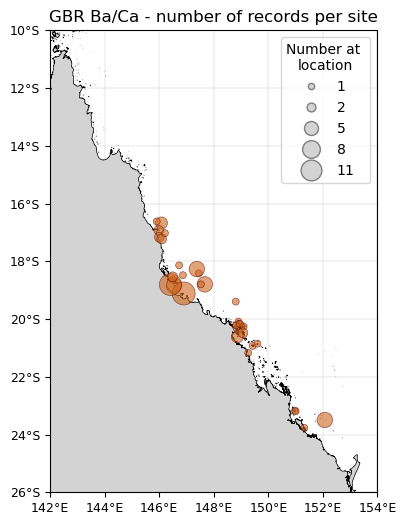

In [20]:
# Display number of records per site using the size of the markers
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Queensland's boundary
qldmap.boundary.plot(ax=ax, color='black', facecolor='lightgrey', linewidth=0.5, zorder=2)

# Plot Ba/Ca records by site, adjusting size based on 'counts' (adjusted for size by a scaling factor multiplier)
scaling_factor = 25
BaCaGRP_gdf.plot.scatter(ax=ax, x='long', y='lat', s=BaCaGRP_gdf['counts']*scaling_factor,
                        color='#CD661D', edgecolor='#570000', linewidth=0.5, alpha = 0.6, label='Ba/Ca', zorder=3)

# Set plot limits
ax.set_xlim(142, 153)
ax.set_ylim(-25, -10.5)

# Set titles and labels
ax.set_title("GBR Ba/Ca - number of records per site")
ax.set(xlabel=None) # as plot.scatter sets to name of input x and y
ax.set(ylabel=None)
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
#plt.yticks(rotation=90, va='centre')
ax.grid(zorder=1,linewidth=0.2)

# make axis labels into degrees south and east
yticks = ax.get_yticks()
yticklabels = [f"{int(abs(y))}°S" for y in yticks] #by takeing the absolute value of the interger and adding °S
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
plt.yticks(fontsize=9)

xticks = ax.get_xticks()
xticklabels = [f"{int(abs(x))}°E" for x in xticks] #by takeing the absolute value of the interger and adding °E
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
plt.xticks(fontsize=9)

# Add legend (option for two seporate legends)
# 1. for Ba/Ca point marker (uncomment the below four lines if desired)
# legend1 = plt.legend(loc='center right') 
# for handle in legend1.legend_handles:
#     handle.set_sizes([scaling_factor]) #to adjust point size in legend to be consistent with the first map
# ax.add_artist(legend1) #plot legend 1

# 2. for size as a display of number of counts
# make an invisible plot without the scaleing factor to get the true size values
invisible_scatter = ax.scatter(BaCaGRP_gdf['long'], BaCaGRP_gdf['lat'], s=BaCaGRP_gdf['counts'], visible=False)
# to define the size bins
size_data = BaCaGRP_gdf['counts']
size_min = min(size_data)
size_max = max(size_data)
# get the metrics (count bins: data min, 1st, 2nd, 3rd quartiles, max (to nearest integer))
handles, labels = invisible_scatter.legend_elements(prop="sizes", num=[size_min,
                                                                  int(size_max/4),
                                                                  int(size_max/4*2),
                                                                  int(size_max/4*3),
                                                                  size_max])
#plot legend 2
legend2 = ax.legend(handles, labels, loc="upper right", title="Number at \nlocation", markerscale=4.5)
legend2.get_title().set_multialignment('center')
for handle in legend2.legend_handles: # set colours, line weight
    handle.set_markerfacecolor('lightgrey')
    handle.set_markeredgecolor('grey')
    handle.set_linewidth(0.5)
    
plt.show()